In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/머신러닝/4장/Credit card

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df1 = pd.read_csv('creditcard.csv')
df1.info()

In [ ]:
df1.head()

In [ ]:
df1.describe()

In [ ]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

def get_train_test_dataset(df=None):

    df_copy = get_preprocessed_df(df)
    X_df = df_copy.iloc[:, :-1]
    Y_df = df_copy.iloc[:, -1]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, test_size=0.3, stratify=Y_df)
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = get_train_test_dataset(df1)

In [ ]:
print('레이블 값 비율')
print(Y_train.value_counts()/Y_train.shape[0] * 100)
print('Label : \n',Y_train.value_counts())

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
 
def clf_eval(Y_test, pred=None):
    confusion = confusion_matrix(Y_test, pred)
    accuracy = accuracy_score(Y_test , pred)
    precision = precision_score(Y_test , pred)
    recall = recall_score(Y_test , pred)
    f1 = f1_score(Y_test,pred)
    print('오차 행렬')
    print(confusion)
    print('acc : {0}, precision : {1}, recall : {2}, F1: {3}'.format(accuracy, precision, recall, f1))

In [ ]:
def model_eval(model, X_train, X_test, Y_train, Y_test):
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    clf_eval(Y_test, pred)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
model_eval(lr, X_train, X_test, Y_train, Y_test)

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
model_eval(lgbm, X_train, X_test, Y_train, Y_test)

# **1. 중요 데이터 분포 변환**

In [ ]:
plt.figure(figsize = [8,4])
sns.distplot(df1['Amount'])

In [ ]:
df1['Amount'].value_counts()

**1-1) Feature scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    df_copy.insert(0, 'Amount_Scaled', amount_n) # DataFrame맨 앞 컬럼으로 입력
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, Y_train, Y_test = get_train_test_dataset(df1)

lr = LogisticRegression()
model_eval(lr, X_train, X_test, Y_train, Y_test)

lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
model_eval(lgbm, X_train, X_test, Y_train, Y_test)

**1-2) Log transformation**

In [ ]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount']) # log1p : log(x+1) <==> np.expm1
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, Y_train, Y_test = get_train_test_dataset(df1)

lr = LogisticRegression()
model_eval(lr, X_train, X_test, Y_train, Y_test)

lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
model_eval(lgbm, X_train, X_test, Y_train, Y_test)

# **2. 이상치 제거**

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = df1.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
import numpy as np

def get_outlier(df, column, weight=1.5): # weight * IQR
    fraud = df[df['Class']==1][column] # 사기당한 데이터
    quantile_25 = np.percentile(fraud.values, 25) # 25%
    quantile_75 = np.percentile(fraud.values, 75) # 75%
     
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index 
    return outlier_index # index 반환

In [ ]:
outlier_index = get_outlier(df=df1, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

In [ ]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount']) # log1p : log(x+1) <==> np.expm1
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

In [ ]:
X_train, X_test, Y_train, Y_test = get_train_test_dataset(df1)

lr = LogisticRegression()
model_eval(lr, X_train, X_test, Y_train, Y_test)

lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
model_eval(lgbm, X_train, X_test, Y_train, Y_test)

# **3. 데이터 증강**

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_over, Y_train_over = smote.fit_sample(X_train, Y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, Y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, Y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(Y_train_over).value_counts())

In [ ]:
lr = LogisticRegression()
model_eval(lr, X_train_over, X_test, Y_train_over, Y_test)

lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
model_eval(lgbm, X_train_over, X_test, Y_train_over, Y_test)

# **Tensorflow**

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential(
    [
        Dense(256, activation="relu"),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics)

In [ ]:
model.fit(X_train_over, Y_train_over, batch_size = 2048, epochs = 30, verbose=1, validation_split=0.1)

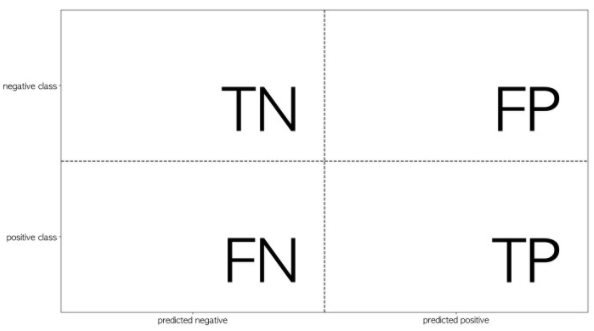